## Perform single-cell quality control to remove erroneous, technical outlier segmentations

Using coSMicQC, we decided on three morphology features (related to shape and intensity) to maximize removal of poor quality nuclei segmentations that could impact downstream analysis.

The original indices are saved as a CSV file to be used for filtering downstream.

## Set papermill parameters

In [1]:
# Papermill notebook parameters
# (including notebook cell tag).
# We set a default here which may be overridden
# during Papermill execution.
# See here for more information:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
plate_id = "BR00117010"

## Import libraries

In [2]:
from pathlib import Path

import cosmicqc
import pandas as pd
from cytodataframe import CytoDataFrame
from pyarrow import parquet

## Load in the plate data to process with only relevant metadata columns

In [3]:
# set path to save qc results
qc_results_dir = Path("./qc_results")
qc_results_dir.mkdir(parents=True, exist_ok=True)

# form a path to the parquet file with single-cell profiles
merged_single_cells = (
    f"/media/jenna/8TB-C/work/JUMP-single-cell/0.download_data/data/plates/{plate_id}/{plate_id}.parquet"
)

# read only the metadata from parquet file
parquet.ParquetFile(merged_single_cells).metadata

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 7390
  num_rows: 289077
  num_row_groups: 32
  format_version: 2.6
  serialized_size: 35722809

In [4]:
# set a list of metadata columns for use throughout
metadata_cols = [
    "Metadata_ImageNumber",
    "Image_Metadata_Site",
    "Metadata_ObjectNumber",
    "Metadata_Plate",
    "Metadata_Well",
    "Image_Metadata_Col",
    "Image_Metadata_Row",
    "Image_FileName_CellOutlines",
    "Image_FileName_NucleiOutlines",
    "Image_FileName_OrigDNA",
    "Image_FileName_OrigRNA",
    "Nuclei_AreaShape_BoundingBoxMaximum_X",
    "Nuclei_AreaShape_BoundingBoxMaximum_Y",
    "Nuclei_AreaShape_BoundingBoxMinimum_X",
    "Nuclei_AreaShape_BoundingBoxMinimum_Y",
]

# read only metadata columns with feature columns used for outlier detection
df_merged_single_cells = pd.read_parquet(
    path=merged_single_cells,
    columns=[
        *metadata_cols,
        "Nuclei_AreaShape_FormFactor",
        "Nuclei_Intensity_MassDisplacement_DNA",
        "Nuclei_AreaShape_Compactness",
    ],
)
print(df_merged_single_cells.shape)
df_merged_single_cells.head()

(289077, 18)


,Metadata_ImageNumber,Image_Metadata_Site,Metadata_ObjectNumber,Metadata_Plate,Metadata_Well,Image_Metadata_Col,Image_Metadata_Row,Image_FileName_CellOutlines,Image_FileName_NucleiOutlines,Image_FileName_OrigDNA,Image_FileName_OrigRNA,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,Nuclei_AreaShape_BoundingBoxMinimum_X,Nuclei_AreaShape_BoundingBoxMinimum_Y,Nuclei_AreaShape_FormFactor,Nuclei_Intensity_MassDisplacement_DNA,Nuclei_AreaShape_Compactness
0,1,1,2,BR00117010,A01,1,1,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,241,58,184,26,0.829066,0.079098,1.206177
1,1,1,3,BR00117010,A01,1,1,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,377,96,331,52,0.826115,0.261505,1.210486
2,2,2,1,BR00117010,A01,1,1,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,1071,48,1030,4,0.712837,0.310597,1.402846
3,2,2,2,BR00117010,A01,1,1,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,973,43,937,6,0.884273,0.106305,1.130873
4,2,2,3,BR00117010,A01,1,1,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,452,45,410,9,0.890275,0.040183,1.123248


## Create mapping for the outlines to the images for CytoDataFrame

In [5]:
# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definintion
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {
    rf"{record['Metadata_Well']}_s{record['Image_Metadata_Site']}--nuclei_outlines\.png":
    rf"r{record['Image_Metadata_Row']:02d}c{record['Image_Metadata_Col']:02d}f{record['Image_Metadata_Site']:02d}p(\d{{2}})-.*\.tiff"
    for record in df_merged_single_cells[
        [
            "Metadata_Well",
            "Image_Metadata_Row",
            "Image_Metadata_Col",
            "Image_Metadata_Site",
        ]
    ].to_dict(orient="records")
}
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('A01_s1--nuclei_outlines\\.png', 'r01c01f01p(\\d{2})-.*\\.tiff')

## Detect technically mis-segmented nuclei

We define technically mis-segmented nuclei as segmentations that include more than one nuclei, under or over-segmentation, or segmentation of background/smudging.

We are using the measurements in two different conditions:


1. Irregular shaped nuclei where the intensity based center is much different than the shape's center

This condition looks to detect any technical outliers with irregular shape and very high difference in centeroids, which can be detecting multiple different types of technical outliers.

- `FormFactor`, which detects how irregular the shape is. 
- `MassDisplacement`, which detects how different the segmentation versus intensity based centeroids are (which can reflect multiple nuclei within one segmentation).
We understand that interesting phenotypes will occur, so we are going to evaluate if this will identify the mis-segmentationsb

### Detect outliers and show single-cell image crops with CytoDataFrame (cdf)

Number of outliers: 1545 (0.53%)
Outliers Range:
Nuclei_AreaShape_FormFactor Min: 0.186143530668769
Nuclei_AreaShape_FormFactor Max: 0.6953710587942782
Nuclei_Intensity_MassDisplacement_DNA Min: 0.8742943217349056
Nuclei_Intensity_MassDisplacement_DNA Max: 8.587189359459938
(1545, 3)


,Nuclei_AreaShape_FormFactor,Nuclei_Intensity_MassDisplacement_DNA,Image_FileName_OrigDNA
91694,0.695371,1.687776,
48588,0.695320,1.017374,

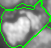
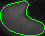

In [6]:
# find irregular shaped nuclei using thresholds that maximizes
# removing most technical outliers and minimizes good cells
feature_thresholds = {
    "Nuclei_AreaShape_FormFactor": -2.35,
    "Nuclei_Intensity_MassDisplacement_DNA": 1.5
}

irregular_nuclei_outliers = cosmicqc.find_outliers(
    df=df_merged_single_cells,
    metadata_columns=metadata_cols,
    feature_thresholds=feature_thresholds
)

irregular_nuclei_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(irregular_nuclei_outliers),
    data_context_dir=f"/media/jenna/8TB-C/work/JUMP-download-images/JUMP-single-cell/0.download_data/data/images/{plate_id}/orig",
    data_outline_context_dir=f"/media/jenna/8TB-C/work/JUMP-download-images/JUMP-single-cell/0.download_data/data/images/{plate_id}/outlines",
    segmentation_file_regex=outline_to_orig_mapping,
)[
    [
        "Nuclei_AreaShape_FormFactor",
        "Nuclei_Intensity_MassDisplacement_DNA",
        "Image_FileName_OrigDNA",
    ]
]


print(irregular_nuclei_outliers_cdf.shape)
irregular_nuclei_outliers_cdf.sort_values(by="Nuclei_AreaShape_FormFactor", ascending=False).head(2)

### Randomly sample outlier rows to visually inspect if the threshold looks to be optimized

,Nuclei_AreaShape_FormFactor,Nuclei_Intensity_MassDisplacement_DNA,Image_FileName_OrigDNA
128919,0.667177,1.027070,
17915,0.691802,0.909502,
147544,0.684497,1.175926,
97537,0.683746,3.750594,
264203,0.664092,0.956389,

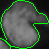
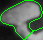
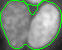
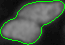

In [7]:
irregular_nuclei_outliers_cdf.sample(n=5, random_state=0)

### Generate a new dataframe to save the original indices for filtering prior to further preprocessing

In [8]:
# Create a new dataframe for failed QC indices
failed_qc_indices = irregular_nuclei_outliers[metadata_cols].copy()
failed_qc_indices["original_index"] = failed_qc_indices.index  # Store original index
failed_qc_indices = failed_qc_indices.reset_index(drop=True)  # Reset index
failed_qc_indices["cqc.formfactor_displacement_outlier"] = True

print(failed_qc_indices.shape)
failed_qc_indices.head()

(1545, 17)


,Metadata_ImageNumber,Image_Metadata_Site,Metadata_ObjectNumber,Metadata_Plate,Metadata_Well,Image_Metadata_Col,Image_Metadata_Row,Image_FileName_CellOutlines,Image_FileName_NucleiOutlines,Image_FileName_OrigDNA,Image_FileName_OrigRNA,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,Nuclei_AreaShape_BoundingBoxMinimum_X,Nuclei_AreaShape_BoundingBoxMinimum_Y,original_index,cqc.formfactor_displacement_outlier
0,167,5,3,BR00117010,A19,19,1,A19_s5--cell_outlines.png,A19_s5--nuclei_outlines.png,r01c19f05p01-ch5sk1fk1fl1.tiff,r01c19f05p01-ch3sk1fk1fl1.tiff,82,138,11,99,271,True
1,174,3,2,BR00117010,A20,20,1,A20_s3--cell_outlines.png,A20_s3--nuclei_outlines.png,r01c20f03p01-ch5sk1fk1fl1.tiff,r01c20f03p01-ch3sk1fk1fl1.tiff,356,40,310,18,284,True
2,207,9,1,BR00117010,A23,23,1,A23_s9--cell_outlines.png,A23_s9--nuclei_outlines.png,r01c23f09p01-ch5sk1fk1fl1.tiff,r01c23f09p01-ch3sk1fk1fl1.tiff,711,73,625,29,352,True
3,208,1,1,BR00117010,A24,24,1,A24_s1--cell_outlines.png,A24_s1--nuclei_outlines.png,r01c24f01p01-ch5sk1fk1fl1.tiff,r01c24f01p01-ch3sk1fk1fl1.tiff,861,192,830,120,355,True
4,257,5,1,BR00117010,B05,5,2,B05_s5--cell_outlines.png,B05_s5--nuclei_outlines.png,r02c05f05p01-ch5sk1fk1fl1.tiff,r02c05f05p01-ch3sk1fk1fl1.tiff,79,57,21,16,452,True


2. Nuclei segmentations with holes and also irregular shaped

We need to include this extra condition as it was discovered that there were more poorly segmented cells not caught, especially those over-segmented nuclei that contained holes, which is not common for a nuclei segmentation.

- `Compactness`, which detects irregular nuclei and nuclei containing holes.

### Detect outliers and show single-cell image crops with CytoDataFrame (cdf)

Number of outliers: 1513 (0.52%)
Outliers Range:
Nuclei_AreaShape_Compactness Min: 1.605079322494332
Nuclei_AreaShape_Compactness Max: 5.372198520180853
(1513, 2)


,Nuclei_AreaShape_Compactness,Image_FileName_OrigDNA
53688,1.605079,
27641,1.605422,

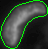
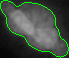

In [9]:
# find mis-segmented nuclei due using thresholds that maximizes
# removing most technical outliers and minimizes good cells
feature_thresholds = {
    "Nuclei_AreaShape_Compactness": 4.05,
}

poor_nuclei_outliers = cosmicqc.find_outliers(
    df=df_merged_single_cells,
    metadata_columns=metadata_cols,
    feature_thresholds=feature_thresholds
)

poor_nuclei_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(poor_nuclei_outliers),
    data_context_dir=f"/media/jenna/8TB-C/work/JUMP-download-images/JUMP-single-cell/0.download_data/data/images/{plate_id}/orig",
    data_outline_context_dir=f"/media/jenna/8TB-C/work/JUMP-download-images/JUMP-single-cell/0.download_data/data/images/{plate_id}/outlines",
    segmentation_file_regex=outline_to_orig_mapping,
)[
    [
        "Nuclei_AreaShape_Compactness",
        "Image_FileName_OrigDNA",
    ]
]


print(poor_nuclei_outliers_cdf.shape)
poor_nuclei_outliers_cdf.sort_values(by="Nuclei_AreaShape_Compactness", ascending=True).head(2)

### Randomly sample outlier rows to visually inspect if the threshold looks to be optimized

,Nuclei_AreaShape_Compactness,Image_FileName_OrigDNA
185724,1.673944,
99612,1.622201,
209053,1.722580,
102623,1.607841,
37864,1.610069,

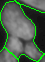
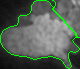
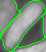

In [10]:
poor_nuclei_outliers_cdf.sample(n=5, random_state=0)

### Save the original indices for failed single cells to compressed CSV files

In [11]:
# Create a new dataframe for poor nuclei outliers
poor_qc_indices = poor_nuclei_outliers[metadata_cols].copy()
poor_qc_indices["original_index"] = poor_qc_indices.index  # Store original index
poor_qc_indices = poor_qc_indices.reset_index(drop=True)  # Reset index
poor_qc_indices["cqc.compactness_outlier"] = True

# Merge both outlier dataframes on metadata columns and original_index
failed_qc_indices = failed_qc_indices.merge(
    poor_qc_indices,
    on=[*metadata_cols, "original_index"],
    how="outer"
)

# Fill missing values with False (ensuring only detected outliers are True)
failed_qc_indices[["cqc.formfactor_displacement_outlier", "cqc.compactness_outlier"]] = (
    failed_qc_indices[["cqc.formfactor_displacement_outlier", "cqc.compactness_outlier"]]
    .fillna(False)
)

# Calculate percentage removed
num_outliers = failed_qc_indices["original_index"].nunique()
total_cells = len(df_merged_single_cells)
percentage_removed = (num_outliers / total_cells) * 100

# Sort by original index to maintain consistent order
failed_qc_indices = failed_qc_indices.sort_values(by="original_index").reset_index(drop=True)

# Save the indices for failed single-cells as a compressed CSV file
failed_qc_indices.to_csv(Path(f"{qc_results_dir}/{plate_id}_failed_qc_indices.csv.gz"), compression="gzip")  # noqa: E501

print(f"Failed QC indices shape: {failed_qc_indices.shape}")
print(f"Percentage of single cells removed: {percentage_removed:.2f}%")
failed_qc_indices.head()

Failed QC indices shape: (2524, 18)
Percentage of single cells removed: 0.87%


/tmp/ipykernel_1967626/3549774745.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  failed_qc_indices[["cqc.formfactor_displacement_outlier", "cqc.compactness_outlier"]]


,Metadata_ImageNumber,Image_Metadata_Site,Metadata_ObjectNumber,Metadata_Plate,Metadata_Well,Image_Metadata_Col,Image_Metadata_Row,Image_FileName_CellOutlines,Image_FileName_NucleiOutlines,Image_FileName_OrigDNA,Image_FileName_OrigRNA,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,Nuclei_AreaShape_BoundingBoxMinimum_X,Nuclei_AreaShape_BoundingBoxMinimum_Y,original_index,cqc.formfactor_displacement_outlier,cqc.compactness_outlier
0,155,2,3,BR00117010,A18,18,1,A18_s2--cell_outlines.png,A18_s2--nuclei_outlines.png,r01c18f02p01-ch5sk1fk1fl1.tiff,r01c18f02p01-ch3sk1fk1fl1.tiff,321,103,267,36,249,False,True
1,160,7,3,BR00117010,A18,18,1,A18_s7--cell_outlines.png,A18_s7--nuclei_outlines.png,r01c18f07p01-ch5sk1fk1fl1.tiff,r01c18f07p01-ch3sk1fk1fl1.tiff,879,192,817,134,258,False,True
2,167,5,3,BR00117010,A19,19,1,A19_s5--cell_outlines.png,A19_s5--nuclei_outlines.png,r01c19f05p01-ch5sk1fk1fl1.tiff,r01c19f05p01-ch3sk1fk1fl1.tiff,82,138,11,99,271,True,False
3,174,3,2,BR00117010,A20,20,1,A20_s3--cell_outlines.png,A20_s3--nuclei_outlines.png,r01c20f03p01-ch5sk1fk1fl1.tiff,r01c20f03p01-ch3sk1fk1fl1.tiff,356,40,310,18,284,True,False
4,207,9,1,BR00117010,A23,23,1,A23_s9--cell_outlines.png,A23_s9--nuclei_outlines.png,r01c23f09p01-ch5sk1fk1fl1.tiff,r01c23f09p01-ch3sk1fk1fl1.tiff,711,73,625,29,352,True,True
